# CS613 Final Project: Cross-Language Image Classification 

In [1]:
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt

## Preprocessing

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        return pickle.load(fo, encoding='bytes')
    
def load_cifar10(file_path):
    train_data, train_labels = [] , []
    for i in range(1,6):
        batch = unpickle(f"{file_path}\\data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels.extend(batch[b'labels'])
    train_data = np.concatenate(train_data, axis=0)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"{file_path}\\test_batch")
    test_data = np.array(test_batch[b'data'])
    test_labels = np.array(test_batch[b'labels'])

    # Reshape the data to (N, 32, 32, 3)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_data = test_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

    return train_data, train_labels, test_data, test_labels

# Save data to CSV
def save_to_csv(data, labels, file_path):
    # Combine labels and data
    combined = np.column_stack((labels, data))
    np.savetxt(file_path, combined, delimiter=",", fmt="%f")
    print(f"Saved {file_path} successfully!")
    
# Prepare data
def normalize_images(data):
    return data / 255.0

# Convert labels to one-hot encoding
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.size, num_classes))
    one_hot[np.arange(labels.size),labels] = 1
    return one_hot

In [4]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
file_path = r"cifar-10-python\\cifar-10-batches-py"
x_train, y_train, x_test, y_test = load_cifar10(file_path)

# Preprocess data
print("Preprocessing data...")
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0],-1)

# Convert labels to one-hot encoding
num_classes = 10
y_train = one_hot_encode(y_train, num_classes)
y_test = one_hot_encode(y_test, num_classes)

# Add biases to X
X_train = np.c_[np.ones((x_train.shape[0], 1)), x_train]
X_test = np.c_[np.ones((x_test.shape[0], 1)), x_test]

Loading CIFAR-10 dataset...
Preprocessing data...


In [5]:
# Save csv files if needed
print("Saving to CSV...")
save_to_csv(x_train, y_train, "train.csv")
save_to_csv(x_test, y_test, "test.csv")
print("CSV files created.")

Saving to CSV...
Saved train.csv successfully!
Saved test.csv successfully!
CSV files created.


## Evaluation Functions

In [6]:
# Model Evaluation
def confusion_matrix(y_true, y_pred):
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes), dtype=int)
    y_true_indices = np.argmax(y_true, axis=1)
    for t, p in zip(y_true_indices, y_pred):
        cm[t, p] += 1
    return cm

def accuracy(y_true, y_pred):
    y_true_label = np.argmax(y_true, axis=1)  #Converting one-hot encoded back to label encoded
    return np.sum(y_true_label == y_pred) / len(y_true_label)


def precision(cm):
    precisions = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        if tp + fp > 0:
            precisions.append(tp / (tp + fp))
        else:
            precisions.append(0)
    return np.mean(precisions)

def recall(cm):
    recalls = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        if tp + fn > 0:
            recalls.append(tp / (tp + fn))
        else:
            recalls.append(0)
    return np.mean(recalls)

def f1_score(cm):
    precisions = precision(cm)
    recalls = recall(cm)
    if (precisions + recalls) > 0:
        return 2 * (precisions * recalls) / (precisions + recalls) 
    else:
        return 0

## Logistic Regression Implementation

In [7]:
class logistic_regression:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

        #Weight Initalization
        self.num_features = None
        self.num_classes = None
        self.weights = None

        # Initialize lists for tracking losses
        self.train_losses = []
        self.test_losses = []

    # Logistic Regression Functions
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def predictProb(self, X):
        y_pred = self.softmax(np.dot(X, self.weights))
        return y_pred
    
    def predict(self, y_pred):
        return np.argmax(self.predictProb(y_pred), axis=1)

    def log_loss(self, y, y_pred, epsilon=1e-15):
        return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
    
    def categorical_crossentropy(self, y, y_pred, epsilon=1e-15):
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon) 
        return -np.mean(np.sum(y * np.log(y_pred), axis=1))
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def gradient_descent(self, X, y, weights, lr):
        y_pred = self.softmax(np.dot(X, weights))
        error = y_pred - y
        gradient = np.dot(X.T, error) / len(y)
        return weights - lr * gradient

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        # Normalize data
        X_train, X_test = normalize_images(X_train), normalize_images(X_test)
        self.num_features = X_train.shape[1]
        self.num_classes = y_train.shape[1]
        self.weights = np.random.randn(self.num_features, self.num_classes)
    
        for epoch in range(self.epochs):
            # Update Weights
            self.weights = self.gradient_descent(X_train, y_train, self.weights, self.learning_rate)

            train_pred = self.softmax(np.dot(X_train, self.weights))
            train_loss = self.categorical_crossentropy(y_train, train_pred)
            self.train_losses.append(train_loss)

            if X_test is not None and y_test is not None:
                test_pred = self.softmax(np.dot(X_test, self.weights))
                test_loss = self.categorical_crossentropy(y_test, test_pred)
                self.test_losses.append(test_loss)
            else:
                test_loss = None

            # if epoch % 100 == 0:
            print(f"Epoch {epoch + 1}/{self.epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

In [8]:
lr = logistic_regression(learning_rate=0.1, epochs=1000)

# Start timer
start_time = time.time()

# Fit the LR model
lr.fit(X_train, y_train, X_test, y_test)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")


Epoch 1/1000: Train Loss = 23.6701, Test Loss = 23.7231
Epoch 2/1000: Train Loss = 20.9292, Test Loss = 20.8743
Epoch 3/1000: Train Loss = 19.5619, Test Loss = 19.5982
Epoch 4/1000: Train Loss = 19.0507, Test Loss = 19.0567
Epoch 5/1000: Train Loss = 18.4171, Test Loss = 18.4268
Epoch 6/1000: Train Loss = 17.5497, Test Loss = 17.5607
Epoch 7/1000: Train Loss = 16.7117, Test Loss = 16.7431
Epoch 8/1000: Train Loss = 16.2427, Test Loss = 16.2649
Epoch 9/1000: Train Loss = 16.0514, Test Loss = 16.0587
Epoch 10/1000: Train Loss = 15.8709, Test Loss = 15.8763
Epoch 11/1000: Train Loss = 15.7119, Test Loss = 15.7175
Epoch 12/1000: Train Loss = 15.5435, Test Loss = 15.5527
Epoch 13/1000: Train Loss = 15.3880, Test Loss = 15.3978
Epoch 14/1000: Train Loss = 15.2274, Test Loss = 15.2408
Epoch 15/1000: Train Loss = 15.0765, Test Loss = 15.0902
Epoch 16/1000: Train Loss = 14.9231, Test Loss = 14.9396
Epoch 17/1000: Train Loss = 14.7780, Test Loss = 14.7940
Epoch 18/1000: Train Loss = 14.6317, Tes

In [9]:
# Generate predictions for train and test sets
train_pred = lr.predict(X_train)

# Calculate training metrics
train_cm = confusion_matrix(y_train, train_pred)
train_accuracy = accuracy(y_train, train_pred)
train_precision = precision(train_cm)
train_recall = recall(train_cm)
train_f1 = f1_score(train_cm)

# Print Metrics
print("\nTraining Evaluation:")
print("Confusion Matrix:\n", train_cm)
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")


test_pred = lr.predict(X_test)

test_cm = confusion_matrix(y_test, test_pred)
test_accuracy = accuracy(y_test, test_pred)
test_precision = precision(test_cm)
test_recall = recall(test_cm)
test_f1 = f1_score(test_cm)

print("\nValidation Evaluation:")
print("Confusion Matrix:\n", test_cm)
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")


Training Evaluation:
Confusion Matrix:
 [[2505  562  652   51   63  425  165  164  159  254]
 [ 785 1990  428   90   84  412  308  179  127  597]
 [ 882  363 1534  107  222  807  668  232   41  144]
 [ 634  609  786  278  158 1294  706  250   66  219]
 [ 644  322 1290  106  388  863  835  378   23  151]
 [ 617  477  859  220  173 1590  628  256   47  133]
 [ 364  396  879  231  303  949 1430  235   44  169]
 [ 695  468  902  156  257  792  529  822   50  329]
 [1921  961  526   52   28  429  142  115  386  440]
 [ 873 1375  423   84   78  373  330  202  149 1113]]
Accuracy: 0.2407
Precision: 0.2532
Recall: 0.2407
F1 Score: 0.2468

Validation Evaluation:
Confusion Matrix:
 [[507 109 142  12   8  92  26  30  29  45]
 [150 371  91  20  25  95  61  32  34 121]
 [200  70 280  26  56 169 121  39  12  27]
 [137 108 168  56  43 263 124  46  12  43]
 [138  64 258  26  77 177 171  61   8  20]
 [134  80 180  25  35 323 126  53  10  34]
 [ 70  92 189  42  60 165 292  49   8  33]
 [150  95 166  18

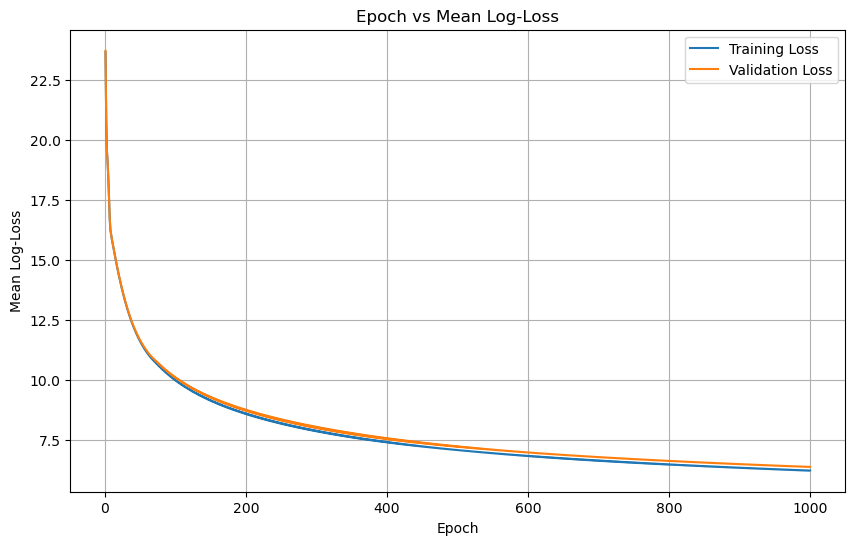

In [10]:
# Plot epoch vs log-loss
epochs = list(range(1, len(lr.train_losses) + 1))

plt.figure(figsize=(10, 6))
plt.plot(epochs, lr.train_losses, label='Training Loss')
plt.plot(epochs, lr.test_losses, label='Validation Loss')

plt.title('Epoch vs Mean Log-Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Log-Loss')
plt.grid(True)
plt.legend()
plt.show()

## SVM Implementation

In [11]:
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_epochs=10):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_epochs = n_epochs
        self.weights = None
        self.accuracy_per_epoch = []

    def fit(self, X, y, num_classes, x_test = None, y_test = None):
        _, n_features = X.shape
        self.weights = np.zeros((num_classes, n_features))
        X, x_test= normalize_images(X), normalize_images(x_test)

        for epoch in range(self.n_epochs):
            for c in range(num_classes):
                y_binary = np.where(y == c, 1, -1)
                w = self.weights[c,:]
                
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, w)) # Check if current sample passes margin condition
                    if condition >= 1:
                        w -= self.learning_rate * (2 * self.lambda_param * w)
                    else:
                        w -= self.learning_rate * (2 * self.lambda_param * w - x_i * y_binary[idx])
                            
                self.weights[c, :] = w
            
            # Evaluate after each epoch
            if x_test is not None and y_test is not None:
                y_pred = self.predict(x_test)
                accuracy = np.mean(y_pred == y_test)
                self.accuracy_per_epoch.append(accuracy)
                print(f"Epoch {epoch + 1}/{self.n_epochs} - Accuracy: {accuracy * 100:.2f}%")
    
    def predictProb(self, X):
        linear_output = np.dot(X, self.weights.T)
        return linear_output
    
    def predict(self, linear_output):
        return np.argmax(self.predictProb(linear_output), axis=1)

In [12]:
# Train the SVM
print("Training SVM...")
svm = SVM(learning_rate=1e-5, lambda_param=0.1, n_epochs=20)

# Decode labels from one-hot encoding to integers
y_train_decoded = np.argmax(y_train, axis=1)
y_test_decoded = np.argmax(y_test, axis=1)

# Start timer
start_time = time.time()

# Fit the SVM model
svm.fit(X_train, y_train_decoded, num_classes, x_test=X_test, y_test=y_test_decoded)

# End timer and print elapsed time
elapsed_time = time.time() - start_time
print(f"Total runtime: {elapsed_time:.2f} seconds")

Training SVM...
Epoch 1/20 - Accuracy: 32.37%
Epoch 2/20 - Accuracy: 34.07%
Epoch 3/20 - Accuracy: 34.87%
Epoch 4/20 - Accuracy: 35.68%
Epoch 5/20 - Accuracy: 35.79%
Epoch 6/20 - Accuracy: 36.03%
Epoch 7/20 - Accuracy: 36.21%
Epoch 8/20 - Accuracy: 36.37%
Epoch 9/20 - Accuracy: 36.52%
Epoch 10/20 - Accuracy: 36.79%
Epoch 11/20 - Accuracy: 36.69%
Epoch 12/20 - Accuracy: 36.92%
Epoch 13/20 - Accuracy: 36.84%
Epoch 14/20 - Accuracy: 36.93%
Epoch 15/20 - Accuracy: 36.94%
Epoch 16/20 - Accuracy: 37.01%
Epoch 17/20 - Accuracy: 36.96%
Epoch 18/20 - Accuracy: 36.95%
Epoch 19/20 - Accuracy: 36.96%
Epoch 20/20 - Accuracy: 36.95%
Total runtime: 84.82 seconds


In [13]:
# Evaluate the model
print("Evaluating SVM...")
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)

# Training Metrics
train_cm_svm = confusion_matrix(y_train, y_pred_train)
train_accuracy_svm = accuracy(y_train, y_pred_train)
train_precision_svm = precision(train_cm_svm)
train_recall_svm = recall(train_cm_svm)
train_f1_svm = f1_score(train_cm_svm)

print("\nSVM Training Evaluation:")
print("Confusion Matrix:\n", train_cm_svm)
print(f"Accuracy: {train_accuracy_svm:.4f}")
print(f"Precision: {train_precision_svm:.4f}")
print(f"Recall: {train_recall_svm:.4f}")
print(f"F1 Score: {train_f1_svm:.4f}")

# Test Metrics
test_cm_svm = confusion_matrix(y_test, y_pred_test)
test_accuracy_svm = accuracy(y_test, y_pred_test)
test_precision_svm = precision(test_cm_svm)
test_recall_svm = recall(test_cm_svm)
test_f1_svm = f1_score(test_cm_svm)

print("\nSVM Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_svm)
print(f"Accuracy: {test_accuracy_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall: {test_recall_svm:.4f}")
print(f"F1 Score: {test_f1_svm:.4f}")

Evaluating SVM...

SVM Training Evaluation:
Confusion Matrix:
 [[1516  351   18  599   26   99  118  335 1527  411]
 [ 118 2532    9  316   22  162  186  200  666  789]
 [ 322  314  331 1223  197  428  822  659  566  138]
 [ 119  422   66 2090   48  759  451  306  431  308]
 [ 194  239  152 1026  681  322  990  843  368  185]
 [  62  307  124 1536   79 1523  422  396  398  153]
 [  44  317   66 1215  155  324 2223  248  224  184]
 [  82  353   49  728  163  298  260 2282  339  446]
 [ 287  440    7  275    8  150   43  106 3220  464]
 [ 131  979   10  245   13  108  148  210  784 2372]]
Accuracy: 0.3754
Precision: 0.4024
Recall: 0.3754
F1 Score: 0.3884

SVM Validation Evaluation:
Confusion Matrix:
 [[297  73   4 118   4  18  25  69 313  79]
 [ 25 485   3  64   4  35  35  41 155 153]
 [ 74  61  66 237  45  81 179 115 118  24]
 [ 24  81  19 418   8 159  89  62  75  65]
 [ 40  47  34 208 133  66 212 160  71  29]
 [ 14  60  24 275  21 311  84  94  94  23]
 [  4  68  18 244  24  55 466  39 

## Ensemble Model

In [14]:
class EnsembleModel:
    def __init__(self, models):
        self.models = models

    def predictProb(self, X):
        # Average probabilities from each model
        probs = [model.predictProb(X) for model in self.models]
        avg_probs = np.mean(probs, axis=0)
        return avg_probs

    def predict(self, X):
        avg_probs = self.predictProb(X)
        return np.argmax(avg_probs, axis=1)

In [16]:
ensemble = EnsembleModel(models=[lr, svm])

In [17]:
# Evaluate the Ensemble Model
y_pred_train = ensemble.predict(X_train)
y_pred_test = ensemble.predict(X_test)

# Training Metrics
train_cm_ensemble = confusion_matrix(y_train, y_pred_train)
train_accuracy_ensemble = accuracy(y_train, y_pred_train)
train_precision_ensemble = precision(train_cm_ensemble)
train_recall_ensemble = recall(train_cm_ensemble)
train_f1_ensemble = f1_score(train_cm_ensemble)

print("\nEnsemble Training Evaluation:")
print("Confusion Matrix:\n", train_cm_ensemble)
print(f"Accuracy: {train_accuracy_ensemble:.4f}")
print(f"Precision: {train_precision_ensemble:.4f}")
print(f"Recall: {train_recall_ensemble:.4f}")
print(f"F1 Score: {train_f1_ensemble:.4f}")

# Test Metrics
test_cm_ensemble = confusion_matrix(y_test, y_pred_test)
test_accuracy_ensemble = accuracy(y_test, y_pred_test)
test_precision_ensemble = precision(test_cm_ensemble)
test_recall_ensemble = recall(test_cm_ensemble)
test_f1_ensemble = f1_score(test_cm_ensemble)

print("\nEnsemble Validation Evaluation:")
print("Confusion Matrix:\n", test_cm_ensemble)
print(f"Accuracy: {test_accuracy_ensemble:.4f}")
print(f"Precision: {test_precision_ensemble:.4f}")
print(f"Recall: {test_recall_ensemble:.4f}")
print(f"F1 Score: {test_f1_ensemble:.4f}")



Ensemble Training Evaluation:
Confusion Matrix:
 [[1533  350   19  590   26  101  118  335 1518  410]
 [ 121 2534   10  308   22  167  185  201  660  792]
 [ 331  313  346 1207  188  436  828  657  556  138]
 [ 121  422   64 2076   49  772  454  305  429  308]
 [ 201  239  160 1008  682  335  995  833  363  184]
 [  65  311  126 1515   78 1536  422  395  398  154]
 [  44  321   70 1201  155  326 2234  248  220  181]
 [  85  355   51  720  157  307  264 2277  337  447]
 [ 290  439    7  272    8  154   43  106 3217  464]
 [ 134  982   11  242   13  109  149  208  782 2370]]
Accuracy: 0.3761
Precision: 0.4029
Recall: 0.3761
F1 Score: 0.3890

Ensemble Validation Evaluation:
Confusion Matrix:
 [[302  73   5 117   3  18  25  69 310  78]
 [ 25 485   3  64   4  35  35  41 154 154]
 [ 75  61  68 234  45  83 179 114 117  24]
 [ 24  81  18 412   9 163  91  62  75  65]
 [ 41  48  35 204 133  67 214 159  70  29]
 [ 14  60  26 270  21 314  83  94  94  24]
 [  4  68  21 240  22  57 467  40  41  40]